#### Item: Product에 비해 cleansing되어 있음
#### Segment가 너무 많음(일반적으로)
#### 시간이 된다면 Spacy를 사용 여부에 따른 주요 단어 추출 결과를 비교해 보는 것도 좋을 것임
#### Segment 분류 정확도 높이기 위해선 의미상의 Cluster를 만들어야 함
#### 무슨 말이냐면 Item, Segment를 Feature Space에 사영하면 유사한 것끼리 모여있을 것인데, 이들을 대표할 하나의 진짜 Segment를 만들어야 함

#### 일단 Segment만 가지고 Clustering을 해야됨(통합 목적임)
#### 근데 강 교수님께서는 Segment1, 2, 3을 하나로 보고 Feature Space에 사영하는 방법도 제시하심

#### Seg.1, 2, 3을 Spacy로 임베딩하여 벡터화한 뒤, Cluster 구성함(tsne 시각화도 필요함)
#### Cluster 이름을 임의로 명명 후 Train 분류 정확도 계산까지 빠르게 수행하기로 함

In [1]:
import pandas as pd
from unidecode import unidecode
import re
import copy
import spacy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# from wordcloud import WordCloud
# from collections import Counter
# import matplotlib.pyplot as plt
# from fuzzywuzzy import fuzz
# from fuzzywuzzy import process
# from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# import plotly.express as px
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.metrics import f1_score, hamming_loss
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import multilabel_confusion_matrix

pd.set_option('display.max_columns', None)

In [2]:
def explode_df(df, column): # ','로 연결된 값을 구분하여 행 증폭
    input = copy.deepcopy(df)
    input[column] = df[column].str.split(',')
    input = input.explode(column)
    input.dropna(inplace=True)
    input[column] = input[column].str.strip() # 좌우 공백 제거
    input = input[input[column] != '']
    output = input.reset_index(drop=True)
    return output

def text_to_vector(text): # 단일 텍스트를 벡터화
    if isinstance(text, str):  # 문자열 여부 확인
        return nlp_sci(text).vector
    return np.zeros(nlp_sci('dummy').vector.shape)  # 빈값 처리

def item_to_mean_vector(text):  
    if isinstance(text, str):  # 문자열 여부 확인
        tokens = text.split(', ')  # ', ' 기준으로 문자열 분리
        vectors = [nlp_sci(token).vector for token in tokens if token.strip()]  # 각 단어를 벡터화
        if vectors:  # 비어있지 않은 경우
            return np.mean(vectors, axis=0)  # 단어 벡터들의 평균 반환
    return np.zeros(nlp_sci('dummy').vector.shape)  # 빈값 처리

def item_to_sum_vector(text): # 빈도 강조: 특정 단어가 여러 번 등장하면 그 단어의 벡터가 더해져서 영향력 커짐짐
    if isinstance(text, str):  # 문자열 여부 확인
        tokens = text.split(', ')  # ', ' 기준으로 문자열 분리
        vectors = [nlp_sci(token).vector for token in tokens if token.strip()]  # 각 단어를 벡터화
        if vectors:  # 비어있지 않은 경우
            return np.sum(vectors, axis=0)  # 단어 벡터들의 평균 반환
    return np.zeros(nlp_sci('dummy').vector.shape)  # 빈값 처리

In [3]:
file = pd.read_excel(r"\\idalabnas\학생 미팅자료\유창연\DeliveryM_BuyerMatching\한국공학대전달 DB_241119.xlsx")
print(file.shape)
print(file.columns)
file.head()

(7119, 18)
Index(['Reference', 'Country', 'Buyer', 'Classification', 'Website', 'Email',
       'Telephone No.', 'Segment1', 'Segment2', 'Segment3', 'Item', 'Note',
       'Contact', 'Mobile', '열1', '열2', 'Unnamed: 16', 'Unnamed: 17'],
      dtype='object')


,Reference,Country,Buyer,Classification,Website,Email,Telephone No.,Segment1,Segment2,Segment3,Item,Note,Contact,Mobile,열1,열2,Unnamed: 16,Unnamed: 17
0,"중고 레이저, ESTHETIC, LASER, 메타소닉, MEDIHUB",USA,Cosmetic Lasers Only,NaN,https://cosmeticlasersonly.com/,https://cosmeticlasersonly.com/,1 (866) 575-9948,"MEDICAL, AESTHETIC",DERMATOLOGY,MACHINE,"ALMA, CUTERA, CYNERON, LUMENIS",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,COLOMBIA,(AFTER INKED COLOMBIA) SAS,NaN,https://www.afterinkedcolombia.com/,info@afterinkedcolombia.com,"CEL: + (57) 3112784715, 3125228701",AESTHETIC,DERMATOLOGY,"MATERIAL, COSMETICS",TATOO CREAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DERMAPHARMA,Ethiopia,(Badreg Pvt. Ltd. Co)(Mohammed Badrej),NaN,https://www.cpd.badregplc.com/Home,mohajaberty1980@gmail.com,Tel: +251111264015 / +251111264031 / +25191120...,"MEDICAL, AESTHETIC",DERMATOLOGY,"SKINCARE, COSMECEUTICAL, COSMETIC","DERMAL CREAM, GEL",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DERMAPHARMA,Algeria,(Kalos Beauty And Youth)(Atef Al-Ali),NaN,https://kalos-dz.com/,ammoon11@gmail.com,Tel: +21323215756 / +21356001008,"MEDICAL, AESTHETIC",DERMATOLOGY,"SKINCARE, COSMECEUTICAL, COSMETIC","DERMAL CREAM, GEL",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,메디팜소프트,PERU,A JAIME ROJAS REPRESENTACIONES GRLES S A,NaN,https://www.ajaimerojas.com.pe/,ventas@ajaimerojas.com atencionalcliente@ajaim...,(+51) 995-965-204,"MEDICAL, HOSPITAL","neurosurgery, urology, sterilization, OBGYN, e...","EQUIPMENT, MACHINE, INSTRUMENT, DEVICE, MATERI...","CAPNOGRAPH, MONITOR, defibrillator, STERILIZAT...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
file = file[['Buyer', 'Segment1', 'Segment2', 'Segment3', 'Item']]
file = file.map(lambda x: unidecode(x) if isinstance(x, str) else x) # e.g. 'München' → 'Munchen'
file = file.map(lambda x: x.upper() if isinstance(x, str) else x) # 모든 열 대문자문자
file.dropna(inplace=True)
print(file.shape)
print(file.columns)
file

(4879, 5)
Index(['Buyer', 'Segment1', 'Segment2', 'Segment3', 'Item'], dtype='object')


,Buyer,Segment1,Segment2,Segment3,Item
0,COSMETIC LASERS ONLY,"MEDICAL, AESTHETIC",DERMATOLOGY,MACHINE,"ALMA, CUTERA, CYNERON, LUMENIS"
1,(AFTER INKED COLOMBIA) SAS,AESTHETIC,DERMATOLOGY,"MATERIAL, COSMETICS",TATOO CREAM
2,(BADREG PVT. LTD. CO)(MOHAMMED BADREJ),"MEDICAL, AESTHETIC",DERMATOLOGY,"SKINCARE, COSMECEUTICAL, COSMETIC","DERMAL CREAM, GEL"
3,(KALOS BEAUTY AND YOUTH)(ATEF AL-ALI),"MEDICAL, AESTHETIC",DERMATOLOGY,"SKINCARE, COSMECEUTICAL, COSMETIC","DERMAL CREAM, GEL"
4,A JAIME ROJAS REPRESENTACIONES GRLES S A,"MEDICAL, HOSPITAL","NEUROSURGERY, UROLOGY, STERILIZATION, OBGYN, E...","EQUIPMENT, MACHINE, INSTRUMENT, DEVICE, MATERI...","CAPNOGRAPH, MONITOR, DEFIBRILLATOR, STERILIZAT..."
...,...,...,...,...,...
7087,WORLD WIDE TRADERS,OTHERS,OTHERS,SERVICE,WORLD WIDE TRADERS OFFERS A RANGE OF EDUCATION...
7089,WWI SOURCING PVT LTD,OTHERS,OTHERS,EQUIPMENT,WWI SOURCING OFFERS A RANGE OF SERVICES TO FAC...
7094,Y S ENTERPRISES,OTHERS,OTHERS,SERVICES,YS ENTERPRISES SPECIALIZES IN TECHNICAL STAFFI...
7114,ZKTECO BIOMETRICS INDIA PVT. LTD.,OTHERS,OTHERS,SERVICES,ZKTECO'S OFFERINGS ENCOMPASS:\n\nBIOMETRIC VER...


In [5]:
file = file[~file[['Segment1', 'Segment2', 'Segment3', 'Item']].apply(lambda row: row.str.contains(r'\n|\.| is | are | offers | offerings | provides | specializes in |, which', flags=re.IGNORECASE, na=False)).any(axis=1)]
# file = file[~file['Item'].str.contains(r'\n|\.| is | are | offers | offerings | provides | specializes in |, which', flags=re.IGNORECASE, na=False)] # 대소문자 비구분
file = file.apply(lambda col: col.str.strip()) # 좌우 공백 제거
print(file['Item'].unique())
file

['ALMA, CUTERA, CYNERON, LUMENIS' 'TATOO CREAM' 'DERMAL CREAM, GEL'
 'GLOVE, BAG, APRON, MEDICAL PACKAGING SUPPLIES' 'WHEELCHAIR, LIGHT, XRAY'
 'MEDICAL GAS SYSTEMS, WASTEWATER TREATMENT SYSTEMS, WASTE INCINERATORS, AND SALT PROCESSING EQUIPMENT, LIGHT, MONITER, BED, COMPRESSOR, VACCUUM, OXYGEN, LIGHT, SUCTION'
 'PAEDIATRIC BED' 'CONSUMABLE' 'EQUIPMENT, CONSUMABLE'
 'MEDICAL GAS SUPPLIER, VACCUM, OXYGEN, AIR'
 'TRENDELENBURG POSITIONING SYSTEM, NEEDLE, SCISSOR, LIFTER, CLIP'
 'MRI, CT' 'MASK, ADHESIVE, SYRINGE, NEEDLE, FORCEP'
 'ADENNA, ADVOCATE, BIOTECHINNOVA, CAREX, COMMON GOOD, GENTEEL, IHEALTH, LOCK LACES, MED EXPRESS, MICELLE, OFS, OPE ELITE, PETTEST, SAGAFORM, SURESHIELD, UNIVERSAL, ARTHRITIS, DIABETES CARE, DISPOSABLES, HYPERTENSION, MARKDOWNS, DENT, DING, PROTECTIVE EQUIPMENT, PAIN MANAGEMENT, SEASONAL PRODUCTS'
 'LASER, CANDELA, ALMA, LUMENIS, CYNOSURE'
 'GLOVE, CATHETER, VENOCLYSIS, BLOOD TRASFUSION, DRIPPER, VAGINAL SPECULUM, CYTOBRUSH, SPATULA, OXYGEN MASK, THERMOMETER, SYR

,Buyer,Segment1,Segment2,Segment3,Item
0,COSMETIC LASERS ONLY,"MEDICAL, AESTHETIC",DERMATOLOGY,MACHINE,"ALMA, CUTERA, CYNERON, LUMENIS"
1,(AFTER INKED COLOMBIA) SAS,AESTHETIC,DERMATOLOGY,"MATERIAL, COSMETICS",TATOO CREAM
2,(BADREG PVT. LTD. CO)(MOHAMMED BADREJ),"MEDICAL, AESTHETIC",DERMATOLOGY,"SKINCARE, COSMECEUTICAL, COSMETIC","DERMAL CREAM, GEL"
3,(KALOS BEAUTY AND YOUTH)(ATEF AL-ALI),"MEDICAL, AESTHETIC",DERMATOLOGY,"SKINCARE, COSMECEUTICAL, COSMETIC","DERMAL CREAM, GEL"
5,A PACK DISTRIBUTION LTD,MEDICAL,GENERAL,CONSUMABLES,"GLOVE, BAG, APRON, MEDICAL PACKAGING SUPPLIES"
...,...,...,...,...,...
4597,"VICTORY EIGHT ENTERPRISE CO.,LTD",MEDICAL,DERMATOLOGY,MACHINE,"PIGMENT LASER, RF, HIFU, IPL, LLLT, BODY CONTO..."
4600,VITA NEEDLE COMPANY,MEDICAL,HOSPITAL,CONSUMABLES,"SMALL DIAMETER TUBING, CUSTOM FABRICATED PARTS..."
4604,WINMED,MEDICAL,HOSPITAL,EQUIPMENT,"LIPOSUCTION, LASER, TATTO REMOVAL, FACIAL BLUS..."
4625,XODUS MEDICAL INC,MEDICAL,"ORTHOPEDIC, REHABILITATION","EQUIPMENT, INSTRUMENT, MACHINE, CONSUMABLES","ELECTRODE, ELECTROSURGICAL PENCIL, NEEDLE"


In [6]:
sg_df = file[['Segment1', 'Segment2', 'Segment3']]
sg_df.reset_index(drop=False, inplace=True)

sg1_xp = explode_df(sg_df, 'Segment1')
sg2_xp = explode_df(sg1_xp, 'Segment2')
sg3_xp = explode_df(sg2_xp, 'Segment3')
sg3_xp

,index,Segment1,Segment2,Segment3
0,0,MEDICAL,DERMATOLOGY,MACHINE
1,0,AESTHETIC,DERMATOLOGY,MACHINE
2,1,AESTHETIC,DERMATOLOGY,MATERIAL
3,1,AESTHETIC,DERMATOLOGY,COSMETICS
4,2,MEDICAL,DERMATOLOGY,SKINCARE
...,...,...,...,...
2313,4625,MEDICAL,REHABILITATION,INSTRUMENT
2314,4625,MEDICAL,REHABILITATION,MACHINE
2315,4625,MEDICAL,REHABILITATION,CONSUMABLES
2316,4626,MEDICAL,DERMATOLOGY,MACHINE


In [7]:
nlp_sci = spacy.load('en_core_sci_lg')

vec_df = copy.deepcopy(sg3_xp[['Segment1', 'Segment2', 'Segment3']])
for col in tqdm(vec_df.columns):
    vec_df[col] = vec_df[col].apply(text_to_vector)
vec_df

c:\Users\99kit\AppData\Local\Programs\Python\Python311\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_sci_lg' (0.5.4) was trained with spaCy v3.7.4 and may not be 100% compatible with the current version (3.8.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
c:\Users\99kit\AppData\Local\Programs\Python\Python311\Lib\site-packages\spacy\language.py:2232: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]
100%|██████████| 3/3 [00:10<00:00,  3.39s/it]


,Segment1,Segment2,Segment3
0,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.0730805, 0.0833669, 0.139924, -0.167363, -0..."
1,"[0.161048, 0.0581147, -0.00110614, -0.325219, ...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.0730805, 0.0833669, 0.139924, -0.167363, -0..."
2,"[0.161048, 0.0581147, -0.00110614, -0.325219, ...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[-0.375515, 0.202812, 0.220907, 0.155582, -0.3..."
3,"[0.161048, 0.0581147, -0.00110614, -0.325219, ...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.21049, 0.135716, 0.113178, -0.273918, -0.57..."
4,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
2313,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0788371, 0.243691, -0.176993, -0.0798443, -...","[0.178441, 0.323571, 0.0821582, -0.342254, -0...."
2314,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0788371, 0.243691, -0.176993, -0.0798443, -...","[0.0730805, 0.0833669, 0.139924, -0.167363, -0..."
2315,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0788371, 0.243691, -0.176993, -0.0798443, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2316,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.0730805, 0.0833669, 0.139924, -0.167363, -0..."


In [12]:
print(sg3_xp.Segment1.nunique())
sg3_xp.Segment1.unique()

10


array(['MEDICAL', 'AESTHETIC', 'OTHERS', 'VENERINARY', 'HOSPITAL',
       'DENTAL', 'VETERINARY', 'PROCUREMENT', 'HEALTHCARE',
       'PERSONAL SERVICES'], dtype=object)

In [10]:
print(sg3_xp.Segment2.nunique())
sg3_xp.Segment2.unique()

133


array(['DERMATOLOGY', 'GENERAL', 'RADIOLOGY', 'HOSPITAL', 'PAEDIATRIC',
       'EVENT CATERING', 'AIRLINE CATERING', 'RESTAURANTS & HOTELS',
       'HARDWARE', 'LUMBER', 'BUILDING SUPPLIES', 'LABORATORY',
       'GYNECOLOGY', 'GENERAL SURGERY', 'UROLOGY AND LAPAROSCOPY',
       'OBGYN', 'DIAGNOSTIC', 'VETERINARY', 'INTERNAL MEDICINE',
       'SURGERY', 'ALL', 'IMPLANTOLOGY', 'PROSTHETIC', 'ORTHODONTIC',
       'ENDODONTIC', 'UROLOGY', 'OPHTHALMOLOGY', 'ANESTHESIA', 'IMPLANT',
       'RESTORATIVE', 'ER', 'CARDIOLOGY', 'GASTOENTEROLOGY', 'ORTHOPEDIC',
       'NEUROLOGY', 'REHABILIATION', 'PLASTIC SURGERY', 'SALON', 'SPA',
       'USRGERY', 'ORTHOPEDICS', 'AESTHETIC SHOP',
       'GENERAL MEDICINE (HOSPITAL SUPPLIES)', 'CADCAM',
       'ELECTROMEDICINE', 'NEONATOLOGY', 'AESTHETIC',
       'GENERAL MEDICAL SUPPLIES', 'PERIODONTIC', 'PEDIATRIC', 'RENAL',
       'VASCULAR', 'MEDICAL-SURGICAL', 'TRAUMATOLOGY', 'REHABILITATION',
       'GASTROLOGY', 'HOME MEDICAL EQUIPMENT', 'PATIENT CARE',
  

In [11]:
print(sg3_xp.Segment3.nunique())
sg3_xp.Segment3.unique()

43


array(['MACHINE', 'MATERIAL', 'COSMETICS', 'SKINCARE', 'COSMECEUTICAL',
       'COSMETIC', 'CONSUMABLES', 'EQUIPMENT', 'SERVICES', 'RETAIL',
       'INSTRUMENT', 'PARTS', 'A/S SERVICE', 'INSTURMENT', 'MEDICINE',
       'SOLUTION', 'CONSUMABLE', 'DEVICE', 'INJECTABLE', 'TREATMENT',
       'DIAGNOSTICS', 'DIAGNOSTIC', 'PHARMACEUTICAL', 'BIO', 'ALL',
       'REPAIR', 'FACILITIES', 'ORTHOPEDICS', 'ENDOCRINOLOGY', 'UROLOGY',
       'REHABILITATION', 'SURGERY', 'FURNITURE', 'OTHERS', 'INJECTION',
       'LASER MACHINE', 'DIGITAL DENTISTRY', 'ANESTHESIA',
       'CREATIVE SERVICES', 'INJECTABLES', 'ORTHODONTIC', 'HANDPIECE',
       'CADCAM'], dtype=object)

In [13]:
# for col in vec_df.columns:
#     vectors = np.stack(vec_df[col].values)  # 각 행의 벡터를 numpy 배열로 변환
    
#     unique_vectors = np.unique(np.round(vectors, decimals=5), axis=0) # 벡터를 소수점 5자리로 반올림 후 고유 벡터 추출(벡터화 후 소수점 차이에 따른 중복 제거 실패 예방)
#     print(f"Column: {col} - Original Vectors: {len(vectors)}, Unique Vectors: {len(unique_vectors)}")
    
#     # t-SNE로 차원 축소
#     adjusted_perplexity = min(5, len(unique_vectors) // 2)  # 데이터 샘플 수에 따라 perplexity 조정
#     if adjusted_perplexity < 5:  # 너무 작아질 경우 처리
#         print(f"Skipping {col} due to insufficient unique vectors for t-SNE.")
#         continue
    
#     tsne = TSNE(n_components=2, random_state=42, perplexity=adjusted_perplexity, n_iter=1000) # 일반적으로 Perplexity 값은 5~50 사이가 좋다
#     tsne_results = tsne.fit_transform(unique_vectors)
    
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1])
#     plt.title(f"t-SNE Visualization of Unique {col} Vectors")
#     plt.xlabel("t-SNE Dimension 1")
#     plt.ylabel("t-SNE Dimension 2")
#     plt.show()

In [14]:
# for col in vec_df.columns:
#     vectors = np.stack(vec_df[col].values)  # 각 행의 벡터를 numpy 배열로 변환
    
#     unique_vectors = np.unique(np.round(vectors, decimals=5), axis=0) # 벡터를 소수점 5자리로 반올림 후 고유 벡터 추출(벡터화 후 소수점 차이에 따른 중복 제거 실패 예방)
#     print(f"Column: {col} - Original Vectors: {len(vectors)}, Unique Vectors: {len(unique_vectors)}")
    
#     # t-SNE로 차원 축소
#     adjusted_perplexity = min(5, len(unique_vectors) // 2)  # 데이터 샘플 수에 따라 perplexity 조정
#     if adjusted_perplexity < 5:  # 너무 작아질 경우 처리
#         print(f"Skipping {col} due to insufficient unique vectors for t-SNE.")
#         continue
    
#     tsne = TSNE(n_components=2, random_state=42, perplexity=adjusted_perplexity, n_iter=1000)  # t-SNE 차원 축소
#     tsne_results = tsne.fit_transform(unique_vectors)
    
#     # K-Means 클러스터링 적용
#     kmeans = KMeans(n_clusters=9, random_state=42)  # 클러스터 수는 5로 설정, 필요에 따라 조정
#     kmeans_labels = kmeans.fit_predict(tsne_results)  # t-SNE 결과에 대해 클러스터링 수행
    
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=kmeans_labels, palette='turbo', legend='full')
#     plt.title(f"t-SNE Visualization of Unique {col} Vectors with K-Means Clusters")
#     plt.xlabel("t-SNE Dimension 1")
#     plt.ylabel("t-SNE Dimension 2")
#     plt.show()

In [15]:
# print(tsne_results.shape)
# tsne_results

In [16]:
# print(kmeans_labels.shape)
# kmeans_labels

Column: Segment1 - Original Vectors: 2318, Unique Vectors: 10


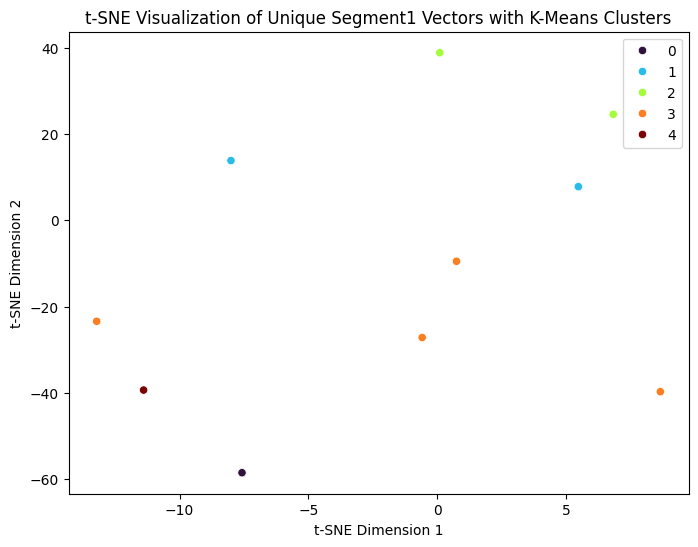

Column: Segment2 - Original Vectors: 2318, Unique Vectors: 113


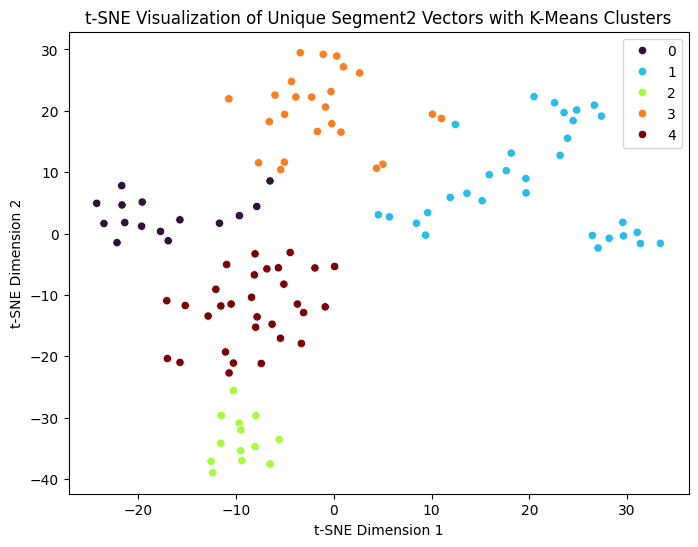

Column: Segment3 - Original Vectors: 2318, Unique Vectors: 37


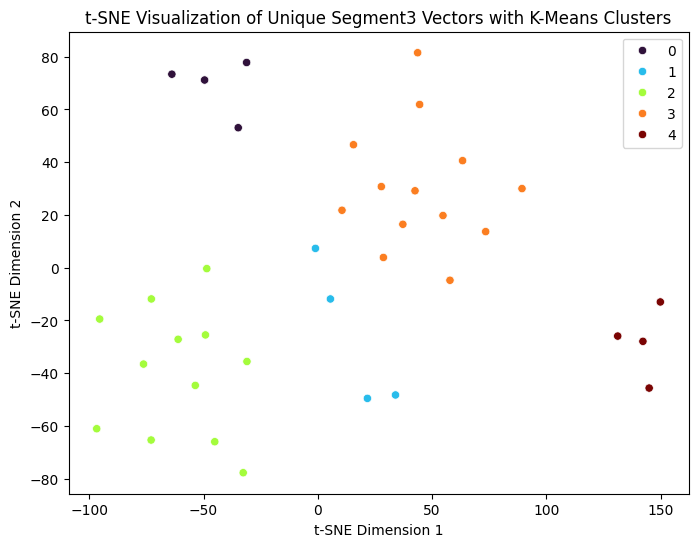

,Segment1_vec,Segment2_vec,Segment3_vec,Segment1_cluster,Segment2_cluster,Segment3_cluster,Segment1,Segment2,Segment3,index
0,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.0730805, 0.0833669, 0.139924, -0.167363, -0...",2,0,1,MEDICAL,DERMATOLOGY,MACHINE,0
1,"[0.161048, 0.0581147, -0.00110614, -0.325219, ...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.0730805, 0.0833669, 0.139924, -0.167363, -0...",3,0,1,AESTHETIC,DERMATOLOGY,MACHINE,0
2,"[0.161048, 0.0581147, -0.00110614, -0.325219, ...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[-0.375515, 0.202812, 0.220907, 0.155582, -0.3...",3,0,2,AESTHETIC,DERMATOLOGY,MATERIAL,1
3,"[0.161048, 0.0581147, -0.00110614, -0.325219, ...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.21049, 0.135716, 0.113178, -0.273918, -0.57...",3,0,3,AESTHETIC,DERMATOLOGY,COSMETICS,1
4,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0,4,MEDICAL,DERMATOLOGY,SKINCARE,2
...,...,...,...,...,...,...,...,...,...,...
2313,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0788371, 0.243691, -0.176993, -0.0798443, -...","[0.178441, 0.323571, 0.0821582, -0.342254, -0....",2,3,2,MEDICAL,REHABILITATION,INSTRUMENT,4625
2314,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0788371, 0.243691, -0.176993, -0.0798443, -...","[0.0730805, 0.0833669, 0.139924, -0.167363, -0...",2,3,1,MEDICAL,REHABILITATION,MACHINE,4625
2315,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0788371, 0.243691, -0.176993, -0.0798443, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,3,4,MEDICAL,REHABILITATION,CONSUMABLES,4625
2316,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.0730805, 0.0833669, 0.139924, -0.167363, -0...",2,0,1,MEDICAL,DERMATOLOGY,MACHINE,4626


In [17]:
updated_df = vec_df.copy()

for col in vec_df.columns:
    vectors = np.stack(updated_df[col].values)  # 각 행의 벡터를 numpy 배열로 변환
    
    unique_vectors, unique_indices = np.unique(np.round(vectors, decimals=5), axis=0, return_inverse=True) # 벡터를 소수점 5자리로 반올림 후 고유 벡터 추출(벡터화 후 소수점 차이에 따른 중복 제거 실패 예방)
    print(f"Column: {col} - Original Vectors: {len(vectors)}, Unique Vectors: {len(unique_vectors)}")
    
    # t-SNE로 차원 축소
    adjusted_perplexity = min(5, len(unique_vectors) - 1)  # 데이터 샘플 수에 따라 perplexity 조정
    if adjusted_perplexity < 5:  # 너무 작아질 경우 처리
        print(f"Skipping {col} due to insufficient unique vectors for t-SNE.")
        updated_df[f"{col}_cluster"] = -1  # 클러스터가 불가능할 경우 -1 할당
        continue
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=adjusted_perplexity, n_iter=1000)  # t-SNE 차원 축소
    tsne_results = tsne.fit_transform(unique_vectors)
    
    # K-Means 클러스터링 적용
    n_clusters = 5 # 근데 각 Segment마다 적용할 cluster 개수를 통일할 필요는 없다!
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)  # 클러스터 수는 5로 설정, 필요에 따라 조정
    kmeans_labels = kmeans.fit_predict(tsne_results)  # t-SNE 결과에 대해 클러스터링 수행
    
    updated_df[f"{col}_cluster"] = kmeans_labels[unique_indices] # 고유 벡터에 대한 클러스터 라벨을 원본 벡터에 매핑
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=kmeans_labels, palette='turbo', legend='full')
    plt.title(f"t-SNE Visualization of Unique {col} Vectors with K-Means Clusters")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()
    
updated_df = pd.concat([updated_df, sg3_xp[['Segment1', 'Segment2', 'Segment3', 'index']]], axis=1)
updated_df.columns = ['Segment1_vec', 'Segment2_vec', 'Segment3_vec', 'Segment1_cluster', 'Segment2_cluster', 
                      'Segment3_cluster', 'Segment1', 'Segment2', 'Segment3', 'index']
updated_df

In [18]:
for gn in range(n_clusters):
    print(f'cluster_{gn}:', updated_df.groupby('Segment1_cluster').Segment1.get_group(gn).unique())
    print(f'cluster_{gn}:', updated_df.groupby('Segment2_cluster').Segment2.get_group(gn).unique())
    print(f'cluster_{gn}:', updated_df.groupby('Segment3_cluster').Segment3.get_group(gn).unique(), '\n')

cluster_0: ['VENERINARY']
cluster_0: ['DERMATOLOGY' 'RADIOLOGY' 'GYNECOLOGY' 'UROLOGY' 'OPHTHALMOLOGY'
 'CARDIOLOGY' 'ORTHOPEDIC' 'NEUROLOGY' 'ORTHOPEDICS' 'TRAUMATOLOGY'
 'NEUROSURGERY' 'HEMATOLOGY' 'ORTHODONTICS' 'DIGITAL DENTISTRY' 'FITNESS']
cluster_0: ['TREATMENT' 'REPAIR' 'SURGERY' 'INJECTION'] 

cluster_1: ['DENTAL' 'PERSONAL SERVICES']
cluster_1: ['GENERAL SURGERY' 'SURGERY' 'ANESTHESIA' 'PLASTIC SURGERY' 'RENAL'
 'VASCULAR' 'PATIENT CARE' 'WOUND CARE' 'RESPIRATORY' 'PHARMACEUTICAL'
 'AIRWAY MANAGEMENT' 'PRIMARY CARE' 'TREATMENT' 'ENTERAL FEEDING'
 'PHARMACEUTICALS' 'PATIENT HANDLING' 'STORAGE SOLUTIONS' 'SPECIALTY CARE'
 'VACCINES' 'PHARMACEUTICAL PACKAGING' 'DIABETIC CARE' 'RESPIRATORY CARE'
 'ORAL SURGERY' 'VASCULAR SURGERY' 'INJECTION SYSTEMS' 'BLOOD COLLECTION'
 'CRITICAL CARE' 'MAXILLOFACIAL SURGERY' 'DIABETES CARE'
 'MEDICATION DELIVERY' 'INFECTION']
cluster_1: ['MACHINE' 'UROLOGY' 'LASER MACHINE' 'ANESTHESIA'] 

cluster_2: ['MEDICAL' 'HOSPITAL']
cluster_2: ['AIRLINE CAT

In [19]:
updated_df['Segment_cluster'] = (updated_df['Segment1_cluster'].astype(str) + updated_df['Segment2_cluster'].astype(str) + updated_df['Segment3_cluster'].astype(str)).astype(int)
print(updated_df['Segment_cluster'].nunique())
print(updated_df['Segment_cluster'].unique())
updated_df

73
[201 301 302 303 204 203 304 234 202 232 231 242 442 422 443 432 433 212
 222 233  32  34 214 224 122 142 141 332 334 132 134 131 112 114 111 144
 221 211 223 321 323 311 213 322 102 101 342 200 210 230 220 124 121 244
 241 312 313 331 314 324 104 341 143 133 103 123 243 343 240 113 333  14
  44]


,Segment1_vec,Segment2_vec,Segment3_vec,Segment1_cluster,Segment2_cluster,Segment3_cluster,Segment1,Segment2,Segment3,index,Segment_cluster
0,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.0730805, 0.0833669, 0.139924, -0.167363, -0...",2,0,1,MEDICAL,DERMATOLOGY,MACHINE,0,201
1,"[0.161048, 0.0581147, -0.00110614, -0.325219, ...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.0730805, 0.0833669, 0.139924, -0.167363, -0...",3,0,1,AESTHETIC,DERMATOLOGY,MACHINE,0,301
2,"[0.161048, 0.0581147, -0.00110614, -0.325219, ...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[-0.375515, 0.202812, 0.220907, 0.155582, -0.3...",3,0,2,AESTHETIC,DERMATOLOGY,MATERIAL,1,302
3,"[0.161048, 0.0581147, -0.00110614, -0.325219, ...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.21049, 0.135716, 0.113178, -0.273918, -0.57...",3,0,3,AESTHETIC,DERMATOLOGY,COSMETICS,1,303
4,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0,4,MEDICAL,DERMATOLOGY,SKINCARE,2,204
...,...,...,...,...,...,...,...,...,...,...,...
2313,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0788371, 0.243691, -0.176993, -0.0798443, -...","[0.178441, 0.323571, 0.0821582, -0.342254, -0....",2,3,2,MEDICAL,REHABILITATION,INSTRUMENT,4625,232
2314,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0788371, 0.243691, -0.176993, -0.0798443, -...","[0.0730805, 0.0833669, 0.139924, -0.167363, -0...",2,3,1,MEDICAL,REHABILITATION,MACHINE,4625,231
2315,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0788371, 0.243691, -0.176993, -0.0798443, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,3,4,MEDICAL,REHABILITATION,CONSUMABLES,4625,234
2316,"[-0.216495, 0.384781, -0.239998, -0.463158, -0...","[0.0622099, 0.195865, -0.158489, -0.126688, -0...","[0.0730805, 0.0833669, 0.139924, -0.167363, -0...",2,0,1,MEDICAL,DERMATOLOGY,MACHINE,4626,201


In [22]:
# 1. 멀티 레이블링
merged_df = copy.deepcopy(updated_df[['Segment1_cluster', 'Segment2_cluster', 'Segment3_cluster', 
                                   'Segment1', 'Segment2', 'Segment3', 'index', 'Segment_cluster']])
merged_df = merged_df.groupby('index', as_index=False).agg(lambda x: ', '.join(map(str, sorted(set(x)))))
copy_file = file.reset_index(drop=False)
merged_df = pd.merge(merged_df, copy_file[['index', 'Item']], on='index')
merged_df['Item_mean_vec'] = merged_df['Item'].apply(item_to_mean_vector)
merged_df['Item_sum_vec'] = merged_df['Item'].apply(item_to_sum_vector)
merged_df

,index,Segment1_cluster,Segment2_cluster,Segment3_cluster,Segment1,Segment2,Segment3,Segment_cluster,Item,Item_mean_vec,Item_sum_vec
0,0,"2, 3",0,1,"AESTHETIC, MEDICAL",DERMATOLOGY,MACHINE,"201, 301","ALMA, CUTERA, CYNERON, LUMENIS","[0.087891504, -0.13548826, -0.025505915, 0.161...","[0.35156602, -0.541953, -0.10202366, 0.6473322..."
1,1,3,0,"2, 3",AESTHETIC,DERMATOLOGY,"COSMETICS, MATERIAL","302, 303",TATOO CREAM,"[-0.0105273, 0.067684, 0.093689, -0.130335, -0...","[-0.0105273, 0.067684, 0.093689, -0.130335, -0..."
2,2,"2, 3",0,"3, 4","AESTHETIC, MEDICAL",DERMATOLOGY,"COSMECEUTICAL, COSMETIC, SKINCARE","203, 204, 303, 304","DERMAL CREAM, GEL","[0.11600135, 0.14599866, 0.1494275, -0.0445385...","[0.2320027, 0.2919973, 0.298855, -0.089077026,..."
3,3,"2, 3",0,"3, 4","AESTHETIC, MEDICAL",DERMATOLOGY,"COSMECEUTICAL, COSMETIC, SKINCARE","203, 204, 303, 304","DERMAL CREAM, GEL","[0.11600135, 0.14599866, 0.1494275, -0.0445385...","[0.2320027, 0.2919973, 0.298855, -0.089077026,..."
4,5,2,3,4,MEDICAL,GENERAL,CONSUMABLES,234,"GLOVE, BAG, APRON, MEDICAL PACKAGING SUPPLIES","[0.10355311, 0.09077259, 0.06930721, -0.162711...","[0.41421244, 0.36309037, 0.27722883, -0.650844..."
...,...,...,...,...,...,...,...,...,...,...,...
344,4597,2,0,1,MEDICAL,DERMATOLOGY,MACHINE,201,"PIGMENT LASER, RF, HIFU, IPL, LLLT, BODY CONTO...","[-0.013158954, 0.05096593, 0.010181912, -0.055...","[-0.1710664, 0.6625571, 0.13236485, -0.7257589..."
345,4600,2,3,4,MEDICAL,HOSPITAL,CONSUMABLES,234,"SMALL DIAMETER TUBING, CUSTOM FABRICATED PARTS...","[0.102921195, 0.0823225, 0.08990251, -0.219917...","[1.1321331, 0.9055475, 0.98892766, -2.4190876,..."
346,4604,2,3,2,MEDICAL,HOSPITAL,EQUIPMENT,232,"LIPOSUCTION, LASER, TATTO REMOVAL, FACIAL BLUS...","[0.028965682, 0.034934185, 0.016479217, -0.169...","[0.637245, 0.76855206, 0.36254275, -3.734184, ..."
347,4625,2,"0, 3","1, 2, 4",MEDICAL,"ORTHOPEDIC, REHABILITATION","CONSUMABLES, EQUIPMENT, INSTRUMENT, MACHINE","201, 202, 204, 231, 232, 234","ELECTRODE, ELECTROSURGICAL PENCIL, NEEDLE","[0.226853, 0.13310523, 0.30064115, -0.30428085...","[0.680559, 0.3993157, 0.9019234, -0.9128425, -..."


In [21]:
# 벡터를 가로로 결합
X_mean = np.vstack(merged_df['Item_mean_vec'].values)  # Item_mean_vec
X_sum = np.vstack(merged_df['Item_sum_vec'].values)  # Item_sum_vec
X = np.hstack((X_mean, X_sum))  # 두 벡터를 가로 방향으로 결합

# MultiLabel Binarizer로 y를 이진 벡터로 변환
y_raw = merged_df['Segment1_cluster'].apply(lambda x: list(map(int, x.split(', '))))  # 다중 레이블 리스트화
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_raw)

# 2. Train-Test 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. RandomForest를 사용한 MultiOutputClassifier 모델 구축
base_rf = RandomForestClassifier(n_estimators=100, random_state=42)
multi_rf = MultiOutputClassifier(base_rf)

# 모델 훈련
multi_rf.fit(X_train, y_train)

# 4. 예측 및 평가
y_pred = multi_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_.astype(str)))

Accuracy Score: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.85      0.99      0.91        89
           3       0.90      0.73      0.80        48
           4       0.00      0.00      0.00         1

   micro avg       0.86      0.81      0.83       152
   macro avg       0.35      0.34      0.34       152
weighted avg       0.78      0.81      0.79       152
 samples avg       0.82      0.78      0.79       152



c:\Users\99kit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\99kit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
# 벡터를 가로로 결합
X_mean = np.vstack(merged_df['Item_mean_vec'].values)  # Item_mean_vec
X_sum = np.vstack(merged_df['Item_sum_vec'].values)  # Item_sum_vec
X = np.hstack((X_mean, X_sum))  # 두 벡터를 가로 방향으로 결합

# MultiLabel Binarizer로 y를 이진 벡터로 변환
y_raw = merged_df['Segment3_cluster'].apply(lambda x: list(map(int, x.split(', '))))  # 다중 레이블 리스트화
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_raw)

# 2. Train-Test 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. RandomForest를 사용한 MultiOutputClassifier 모델 구축
base_rf = RandomForestClassifier(n_estimators=100, random_state=42)
multi_rf = MultiOutputClassifier(base_rf)

# 모델 훈련
multi_rf.fit(X_train, y_train)

# 4. 예측 및 평가
y_pred = multi_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_.astype(str)))

Accuracy Score: 0.44
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.82      0.69      0.75        54
           2       0.74      0.77      0.75        56
           3       0.93      0.54      0.68        24
           4       0.73      0.74      0.74        43

   micro avg       0.78      0.71      0.74       177
   macro avg       0.64      0.55      0.58       177
weighted avg       0.79      0.71      0.74       177
 samples avg       0.76      0.74      0.71       177



c:\Users\99kit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\99kit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\99kit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [ ]:
# 실루엣 점수
# CV 변동계수 점수